In [42]:
import numpy as np
import scipy.io as scio
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os
import skimage
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import DictionaryLearning
import seaborn as sns
sns.set()
from sklearn import metrics

In [5]:
hr_df  = pd.read_csv('HR_FullTimeSeries.csv') # HR, EDA Data Extraction
hr_data = hr_df.drop(['Subject', 'FinalMS', '1350'], axis=1).to_numpy()
eda_df = pd.read_csv('EDA_FullTimeSeries.csv')
eda_data = eda_df.drop(['Subject', 'FinalMS', '1350'], axis=1).to_numpy()
ms_end_labels = hr_df['FinalMS'].to_numpy() # End True Labels for Logistic Regression
#np.savetxt("MS_EndLabels.csv",ms_end_labels,delimiter = ",")
# Normalization
hr_data_normalized = np.divide(hr_data - np.mean(hr_data, axis=1, keepdims=True), np.std(hr_data, axis=1, keepdims=True))
eda_data_normalized = np.divide(eda_data - np.mean(eda_data, axis=1, keepdims=True), np.std(eda_data, axis=1, keepdims=True))

# MS Read in
ms_df = pd.read_csv('MS_DateTime_Complete_test.csv')
num_subjects = hr_data.shape[0]
num_train = int(num_subjects * train_split)
num_test = num_subjects - num_train
length = hr_data.shape[1]

hr_data = hr_data.T
eda_data = eda_data.T

hr_data_normalized = hr_data_normalized.T
eda_data_normalized = eda_data_normalized.T

In [6]:
i = 0
ms_interval_labels = np.ones((15, num_subjects)) * 2 # Labeing high as 2, anything not given presumed to be an early end, which corresponds to high
subject_names = hr_df['Subject'].unique() # so we only use subjects with phys data
grouped = ms_df.groupby(['Subject_Code'])

for subject in subject_names:
   
    subj_data =  grouped.get_group(subject)
    subj_ms_scores = subj_data['MSscore'].to_numpy()[1:]
    subj_ms_scores = np.where(subj_ms_scores <=3, 0, subj_ms_scores)
    subj_ms_scores = np.where((subj_ms_scores > 3) & (subj_ms_scores < 8), 1, subj_ms_scores)
    subj_ms_scores = np.where((subj_ms_scores >= 8 ) , 2, subj_ms_scores)
    
    if len(subj_ms_scores) < 15:
        subj_ms_scores = np.pad(subj_ms_scores, (0,15 - len(subj_ms_scores)), 'constant', constant_values = (2))
    if len(subj_ms_scores) > 15:
        subj_ms_scores = subj_ms_scores[:-1]
  
    ms_interval_labels[:, i] = subj_ms_scores
    
    i = i + 1
    #subj_data =  grouped.get_group(subject)
    #print(len(subj_data['MSscore'].to_numpy()))

In [7]:
# Soft Threshold function (With 1/2 added)
def soft2(z, lam):     
    return 0.5*(np.sign(z)*np.maximum(np.abs(z)-lam,0)) 

In [46]:
# Soft Threshold function (From HW)
def soft(z, lam):     
    return np.sign(z)*np.maximum(np.abs(z)-lam,0) 

In [52]:
#Implementation of Alternating Method
def DL(Y, X0, lam, fun = lambda z:0, niter=1000, eps=1e-4): 
    '''
    Input:
        Y:     Observation Matrix
        X0:    intilalization 
        lam:   regularization parameter
        fun:   user defined function (e.g objective function)
        niter: maximum umber of iterations
        eps:   termination crtieria 
        
    Output: 
        A:     (Unitary) Dictionary Matrix 
        X:     Representation Matrix
        out:   objective value at termination 
    '''
    X = X0.copy()
    out_prev = 1e4
    for itr in range(niter):
        U,_,V = np.linalg.svd(Y@X.T,full_matrices=False)
        A = U@V
        X = soft(A.T@Y, lam)
        out = fun(A,X, Y)
        if np.abs(out-out_prev)/np.abs(out_prev)<eps:
           break 
        out_prev = out
    return A, X, out 

In [58]:
#Implementation of Alternating Method for double dictionary learning
def DL_2(E, H,  X0, lam, fun = lambda z:0, niter=1000, eps=1e-3): 
    '''
    Input:
        E:     EDA Observation Matrix
        H:     HR Obseration Matrix
        X0:    intilalization 
        lam:   regularization parameter
        fun:   user defined function (e.g objective function)
        niter: maximum umber of iterations
        eps:   termination crtieria 
        
    Intermediate:
        Z = AH.T *H + AE.T * E
    Output: 
        AE:     (Unitary) Dictionary Matrix for EDA
        AH:     (Unitary) Dictionary Matrix for HR
        X:     Representation Matrix
        out:   objective value at termination 
    '''
    X = X0.copy()
    out_prev = 1e4
    for itr in range(niter):
        UE,_,VE = np.linalg.svd(E@X.T,full_matrices=False)
        AE = UE@VE
        UH,_,VH = np.linalg.svd(H@X.T,full_matrices=False)
        AH = UH@VH
        
        Z = AH.T @ H + AE.T @ E
        X = soft2(Z, lam)
        out = fun(AE,AH, X)
        print(np.abs(out-out_prev)/np.abs(out_prev))
        if np.abs(out-out_prev)/np.abs(out_prev)<eps:
           break 
        out_prev = out
    return AE, AH, X, out 

In [69]:
def LoCo(Ux, Uy):
    USx, _, _ = np.linalg.svd(Ux, full_matrices=True)
    USy, _, _ = np.linalg.svd(Uy, full_matrices = True)
    return .5 * np.linalg.norm(Ux.T @ USy[:,1], ord = 2) + .5 * np.linalg.norm(Uy.T @ USx[:,1], ord = 2)

def FOTS(Ux, Uy):
    return np.linalg.norm(Ux - Uy, ord='fro')

In [89]:
E_solo, X_E_Solo, out = DL(E, np.random.rand(E.shape[0], E.shape[1]), lam = ld, fun = obj ,niter=15)
H_solo, X_H_Solo, out = DL(H, np.random.rand(H.shape[0], H.shape[1]), lam = ld, fun = obj ,niter=15)
print(FOTS(Ae, Ah))
print(LoCo(Ae, E_solo))
print(LoCo(Ah, H_solo))

0.0
0.9999999999999996
1.0


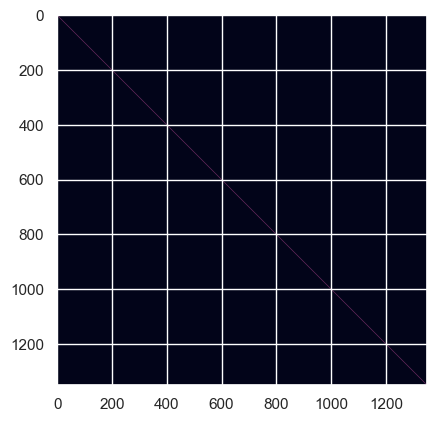

In [98]:
plt.imshow(Ah)
plt.savefig("RawDataLambda10Ah.png")

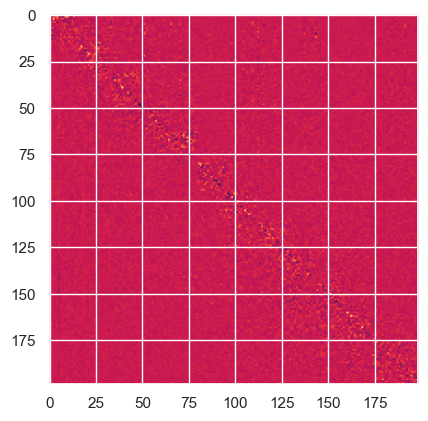

In [85]:
plt.imshow(E_solo[1:200,1:200])
plt.savefig('raw_data_identity.png')

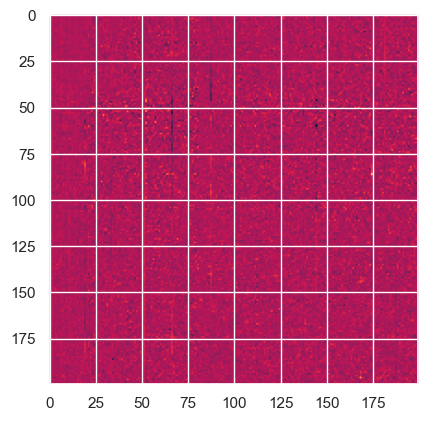

In [86]:
plt.imshow(E_solo[500:700,0:200])
plt.savefig('raw_data_offdiagonal.png')

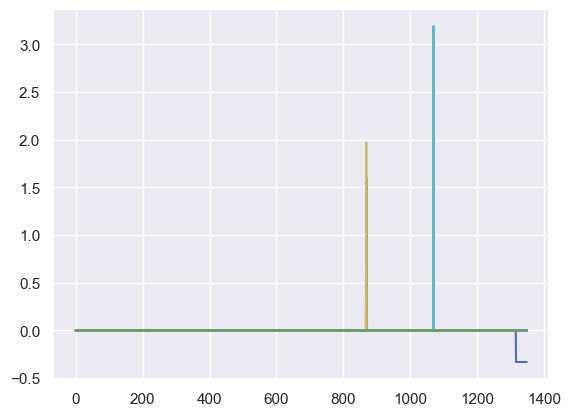

In [99]:
plt.plot(X)
plt.savefig("LowRankX_Raw.png")

In [72]:
#DL(Y, X0, lam, fun = lambda z:0, niter=1000, eps=1e-4): 



In [88]:
np.random.seed(2024)
ld = 10
H = hr_data_normalized 
E = eda_data_normalized
obj2 = lambda AE, AH, X : (1/H.shape[0] ** 2) * (0.5 * np.linalg.norm(E - AE@X, 'fro') ** 2 +  0.5 * np.linalg.norm(H - AH@X, 'fro') ** 2  + ld*np.sum(np.abs(X)))
obj = lambda A,X, Y :0.5*np.linalg.norm(Y-A@X,'fro')**2+ld*np.sum(np.abs(X))
out = np.empty(100)


Ae, Ah, X, out = DL_2(E, H,  np.random.rand(E.shape[0], E.shape[1]), lam=ld, fun = obj2, niter=15)
print(np.linalg.matrix_rank(X))



0.9999945925925926
0.00020698345440080962
4


In [101]:
X.shape

(1350, 73)

Raw Windowed

In [100]:
blocks_raw_hr_full = np.squeeze(skimage.util.view_as_blocks(hr_data_normalized, block_shape = (90, num_subjects)))
blocks_raw_eda_full = np.squeeze(skimage.util.view_as_blocks(eda_data_normalized, block_shape = (90, num_subjects)))
print(blocks_raw_hr_full.shape)


(15, 90, 73)


In [123]:
ld = 1
avg_fots = 0
avg_loco_e = 0
avg_loco_h = 0
avg_rank = 0
X_storage = np.empty(blocks_raw_hr_full.shape)
XE_storage = np.empty(blocks_raw_hr_full.shape)
XH_storage = np.empty(blocks_raw_hr_full.shape)
Ae_storage = np.empty((15,90,90))
Ah_storage = np.empty((15,90,90))
E_storage = np.empty((15,90,90))
H_storage = np.empty((15,90,90))
for i in range(blocks_raw_hr_full.shape[0]):
    #i = 6
    H = blocks_raw_hr_full[i,:,:]
    E = blocks_raw_hr_full[i,:,:]
    Ae, Ah, X, out = DL_2(E, H,  np.random.rand(E.shape[0], E.shape[1]), lam=ld, fun = obj2, niter=15)
    rank = np.linalg.matrix_rank(X)
    
    E_solo, X_E_Solo, out = DL(E, np.random.rand(E.shape[0], E.shape[1]), lam = ld, fun = obj ,niter=15)
    H_solo, X_H_Solo, out = DL(H, np.random.rand(H.shape[0], H.shape[1]), lam = ld, fun = obj ,niter=15)
    avg_rank = avg_rank + rank
    avg_fots = avg_fots + FOTS(Ae, Ah)
    avg_loco_e = avg_loco_e + LoCo(Ae, E_solo)
    avg_loco_h = avg_loco_h + LoCo(Ah, H_solo)
    #print(i)

print("Avg FOTS" + str(avg_fots/15))
print("Avg LoCoE" + str(avg_loco_e/15))
print("Avg LoCoH" + str(avg_loco_h/15))
print("Avg Rank" + str(rank/15))
    


0.999981006930237
0.06305425737697815
0.12872879907637352
0.154303457922158
0.1301560499965208
0.10957125394048492
0.07247354193488015
0.05646751242167405
0.05644954817183758
0.0633161630731445
0.07506403883558409
0.07828666646881839
0.0625803483245583
0.05521054696773897
0.040613877661790566
0.9999810036684484
0.060528726845239834
0.14198588644317892
0.20488152336390048
0.18011883398689443
0.12886672398749596
0.09598614129983257
0.07961825596344266
0.058667475593049974
0.04208487978768816
0.03559982686272849
0.03413000435099534
0.02634710086021441
0.017797333897890674
0.013571839312062664
0.9999810106171986
0.051286130235092084
0.11432282120076413
0.19304820870510828
0.22608818378810708
0.21091946720876803
0.150642534258605
0.09638580480355351
0.06070989963004457
0.04172646250390091
0.02065217210804765
0.012875442635906936
0.010990992749576283
0.008075229410164437
0.008434323654911154
0.9999810196264909
0.05789293650384355
0.13343333593064488
0.19865064398299742
0.20280307719957155
0.

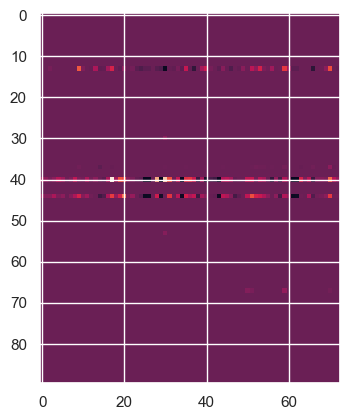

In [127]:
plt.imshow(X)
plt.savefig("WindowedDataX.png")

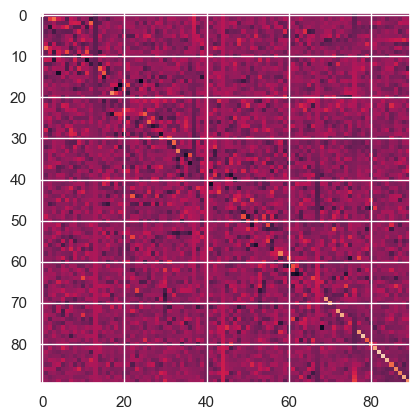

In [128]:
plt.imshow(Ae)
plt.savefig("WindowedDataAe.png")

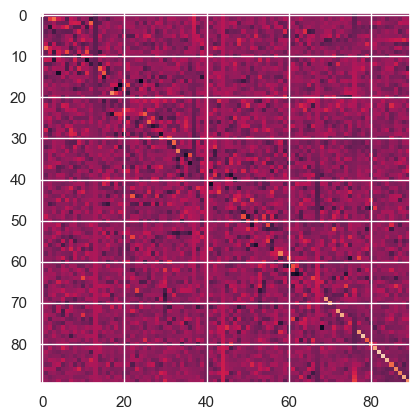

In [129]:
plt.imshow(Ah)
plt.savefig("WindowedDataAh.png")